In [1]:
import numpy as np
import pandas as pd
import string
import seaborn as sns
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

### Не успел задокументировать

In [2]:
df = pd.read_csv('./data/SMSSpamCollection', sep='\t', names=['label', 'text'])
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df['label'] = df['label'].apply(lambda x: 0 if x == 'ham' else 1)
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
0      4825   4516                             Sorry, I'll call later   30
1       747    653  Please call our customer service representativ...    4

In [5]:
def text_process(msg):
    nopunc =[char for char in msg if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word.lower() for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [6]:
df['text'].head(5).apply(text_process)

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, goes, usf, lives, around, t...
Name: text, dtype: object

In [7]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(df['text'])
print(len(bow_transformer.vocabulary_))

9530


In [8]:
df_bow = bow_transformer.transform(df['text'])
tf_idf_transformer = TfidfTransformer().fit(df_bow)
messages_tf_idf = tf_idf_transformer.transform(df_bow)
print(messages_tf_idf.shape)

(5572, 9530)


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(messages_tf_idf, df['label'], test_size=0.2, random_state=17)

In [10]:
spam_detect_model = MultinomialNB().fit(X_train, Y_train)
predictions = spam_detect_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       970
           1       1.00      0.72      0.84       145

   micro avg       0.96      0.96      0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



Text(51.0, 0.5, 'true')

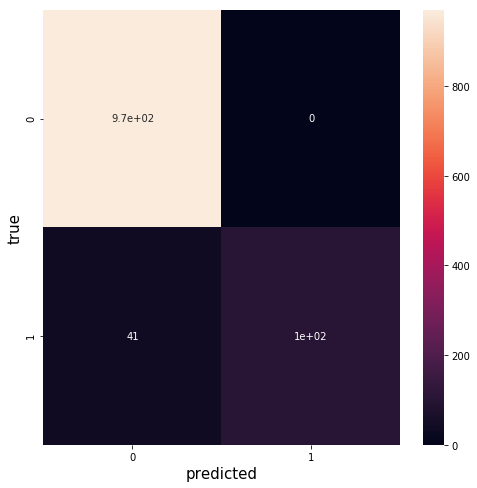

In [11]:
print(classification_report(Y_test, predictions))
cm = confusion_matrix(Y_test, predictions)
plt.figure(figsize = (8, 8))
sns.heatmap(cm, annot=True)
plt.xlabel('predicted', fontsize=15)
plt.ylabel('true', fontsize=15)

### "By a hands"

In [12]:
c_vec = CountVectorizer(lowercase=True, min_df=.00001, stop_words='english')
c_vec.fit(df['text'].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1e-05,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [13]:
X_train = df[0:4457]
X_test = df[4457:]
X_test.index = (range(X_test.shape[0]))
Y_train = X_train['label'].values
Y_test = X_test['label'].values

In [14]:
def spam_ham_probability(Y_train):
    probabilities = np.zeros((2,))
    counts = np.zeros((2,))
    amount = Y_train.shape[0]
    for i in range(amount):
        counts[Y_train[i]] = counts[Y_train[i]] + 1
    probabilities = counts/amount
    return probabilities

In [15]:
spam_ham_probabilities = spam_ham_probability(Y_train)
spam_ham_probabilities

array([0.86493157, 0.13506843])

In [16]:
def prob_xy(c_vec, train_df, Y_train):
    d_y = np.zeros((2,)) + len(c_vec.vocabulary_)
    word_freq = np.zeros((2, len(c_vec.vocabulary_)))
    for i in np.unique(Y_train):
        label_df = train_df[train_df['label'] == i]
        accordance_matrix = c_vec.transform(label_df['text'].values)
        n_xy = np.sum(accordance_matrix, axis=0) + 1
        d_y[i] = d_y[i] + np.sum(accordance_matrix)
        word_freq[i] = n_xy/d_y[i] 
    return word_freq

In [17]:
word_freq = prob_xy(c_vec, X_train, Y_train)
word_freq

array([[2.80938334e-05, 2.80938334e-05, 5.61876668e-05, ...,
        5.61876668e-05, 2.80938334e-05, 2.80938334e-05],
       [6.11892974e-04, 1.44629248e-03, 5.56266340e-05, ...,
        5.56266340e-05, 1.11253268e-04, 5.56266340e-05]])

In [18]:
def classify(c_vec, test_df, word_freq, s_h_probs):
    preds = []
    for sms in test_df['text'].values:
        acc_arr = c_vec.transform([sms]).toarray()
        probabilities = np.zeros((2,))
        for i in range(2):
            probabilities[i] = np.prod(np.power(word_freq[i], acc_arr)) * s_h_probs[i]
        preds.append(np.argmax(probabilities))
    return preds

In [19]:
own_preds = classify(c_vec, X_test, word_freq, spam_ham_probabilities)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       970
           1       0.90      0.97      0.93       145

   micro avg       0.98      0.98      0.98      1115
   macro avg       0.95      0.97      0.96      1115
weighted avg       0.98      0.98      0.98      1115



Text(51.0, 0.5, 'True')

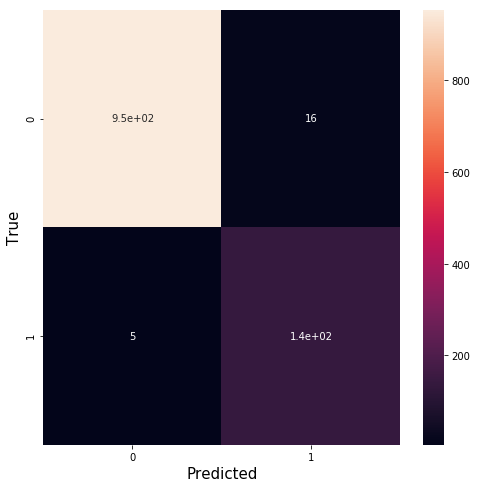

In [20]:
print(classification_report(Y_test, own_preds))
cm = confusion_matrix(Y_test, own_preds)
plt.figure(figsize = (8, 8))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)